# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://deep-learning-su.github.io/assignment-requirements/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from deep_learning_su.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'deep_learning_su/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


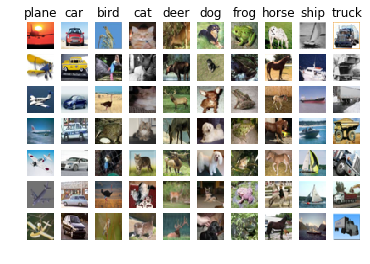

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


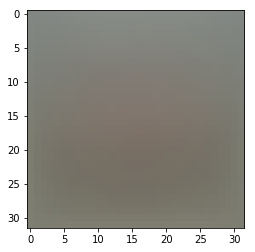

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **deep_learning_su/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from deep_learning_su.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.286961


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from deep_learning_su.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -0.112000 analytic: -0.112000, relative error: 2.512380e-09
numerical: 11.775074 analytic: 11.814149, relative error: 1.656473e-03
numerical: -5.401019 analytic: -5.401019, relative error: 1.231547e-10
numerical: -6.388973 analytic: -6.388973, relative error: 3.661579e-12
numerical: -16.639249 analytic: -16.639249, relative error: 5.954480e-12
numerical: 6.964428 analytic: 6.964428, relative error: 7.065507e-11
numerical: 17.492596 analytic: 17.492596, relative error: 1.587882e-11
numerical: -14.263794 analytic: -14.263794, relative error: 3.450048e-11
numerical: -19.469156 analytic: -19.469156, relative error: 2.150607e-12
numerical: 17.802635 analytic: 17.802635, relative error: 6.012577e-12
numerical: 9.184825 analytic: 9.184825, relative error: 2.034891e-11
numerical: 13.357164 analytic: 13.357164, relative error: 2.090136e-11
numerical: 15.275213 analytic: 15.275213, relative error: 3.376996e-11
numerical: 8.482378 analytic: 8.482378, relative error: 5.200041e-11
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** The used numerical method to calculate an approximation of the derivative is the symetrical difference. This method checks the value of $f$ in a point smaller than $x$ and in a point larger than $x$ -> $x - h$ and $x + h$. That means that the calculation of the derivative can be sensitive to strange behaviour of the function in $[x-h, x+h]$. It means that it is going to compare some strange point (that has nothing to do with the point for which we try to calculate the derivative) to some other point. That can yield strange results.

Example for this can be the function:
$$f(x) = 
  \begin{cases}
    0, & x < 0 \\
    x, & \text{otherwise}
  \end{cases}$$
  
This function is not differentiable in $0$ but in $h$ $/$ $4$ it is. Its derivative there is 1 but the method will try to compare it with a point that is $< 0$ and that will yield the strange (inaccurate) result.

In our loss function exactly this is used. There is an $if margin > 0$ which results in exactly the same function but with multiple variables.

In [11]:
h = 1e-5
f = lambda x: np.max((x, 0.))
grad_check_sparse(f, np.array(1.), np.array(1.0))
grad_check_sparse(f, np.array(h), np.array(1.0))
grad_check_sparse(f, np.array(h/10), np.array(1.0))

numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 5.000445e-13
numerical: 1.000000 analytic: 1.000000, relative error: 0.000000e+00
numerical: 1.000000 analytic: 1.000000, relative error: 0.000000e+00
numerical: 1.000000 analytic: 1.000000, relative error: 0.000000e+00
numerical: 1.000000 analytic: 1.000000, relative error: 0.000000e+00
numerical: 1.000000 analytic: 1.00

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from deep_learning_su.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.286961e+00 computed in 0.090210s
Vectorized loss: 9.286961e+00 computed in 0.014038s
difference: -0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.098448s
Vectorized loss and gradient: computed in 0.012007s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from deep_learning_su.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 797.656320
iteration 100 / 1500: loss 289.644641
iteration 200 / 1500: loss 108.692802
iteration 300 / 1500: loss 43.257575
iteration 400 / 1500: loss 18.992609
iteration 500 / 1500: loss 10.377636
iteration 600 / 1500: loss 7.459205
iteration 700 / 1500: loss 5.920976
iteration 800 / 1500: loss 5.222265
iteration 900 / 1500: loss 4.902853
iteration 1000 / 1500: loss 5.602687
iteration 1100 / 1500: loss 5.546071
iteration 1200 / 1500: loss 5.285888
iteration 1300 / 1500: loss 5.234780
iteration 1400 / 1500: loss 5.268752
That took 8.506566s


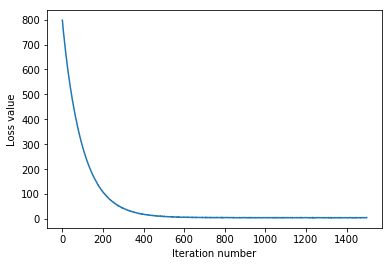

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370551
validation accuracy: 0.394000


Learning Rate: 0.000000.10
Regularization Strength: 50000.000000.1


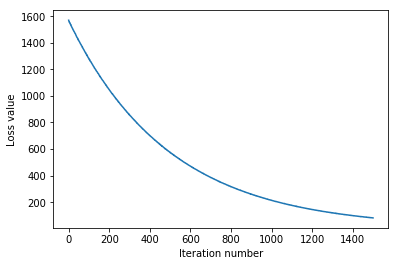

training accuracy: 0.304959
validation accuracy: 0.319000
Learning Rate: 0.000000.10
Regularization Strength: 30000.000000.1


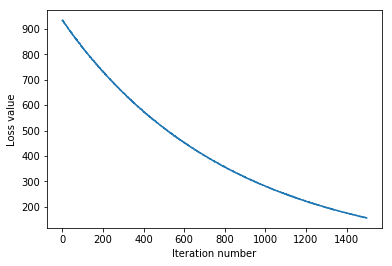

training accuracy: 0.253184
validation accuracy: 0.244000
Learning Rate: 0.000000.10
Regularization Strength: 25000.000000.1


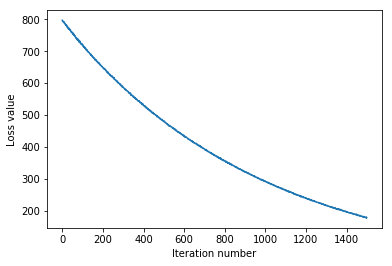

training accuracy: 0.251510
validation accuracy: 0.259000
Learning Rate: 0.000000.10
Regularization Strength: 10000.000000.1


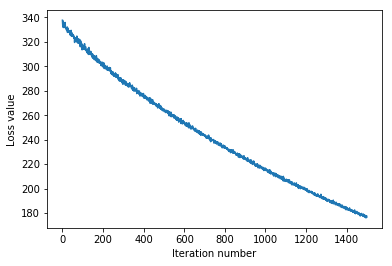

training accuracy: 0.237408
validation accuracy: 0.239000
Learning Rate: 0.000000.10
Regularization Strength: 7000.000000.1


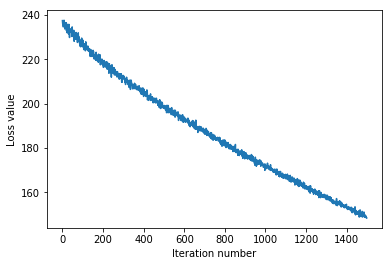

training accuracy: 0.225388
validation accuracy: 0.246000
Learning Rate: 0.000000.10
Regularization Strength: 50000.000000.1


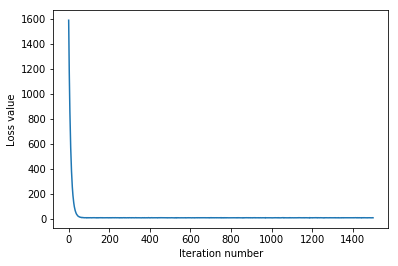

training accuracy: 0.318939
validation accuracy: 0.324000
Learning Rate: 0.000000.10
Regularization Strength: 30000.000000.1


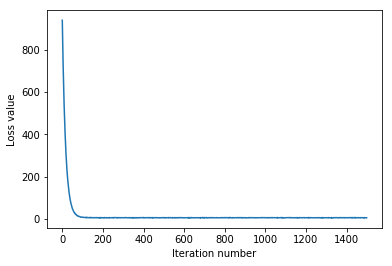

training accuracy: 0.310980
validation accuracy: 0.323000
Learning Rate: 0.000000.10
Regularization Strength: 25000.000000.1


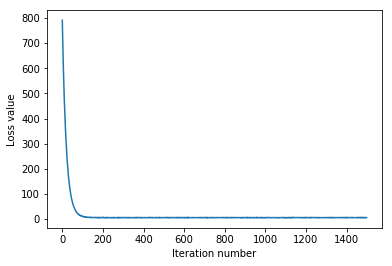

training accuracy: 0.328816
validation accuracy: 0.333000
Learning Rate: 0.000000.10
Regularization Strength: 10000.000000.1


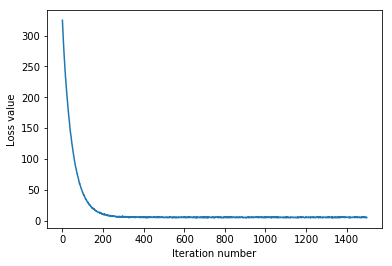

training accuracy: 0.361265
validation accuracy: 0.367000
Learning Rate: 0.000000.10
Regularization Strength: 7000.000000.1


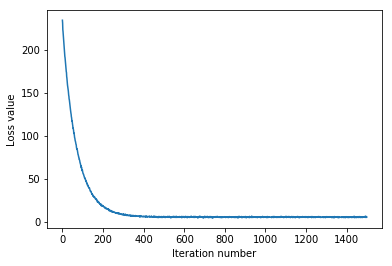

training accuracy: 0.348041
validation accuracy: 0.371000
Learning Rate: 0.000000.10
Regularization Strength: 50000.000000.1


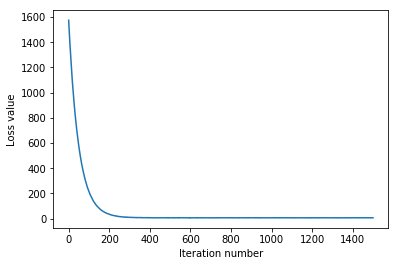

training accuracy: 0.361184
validation accuracy: 0.387000
Learning Rate: 0.000000.10
Regularization Strength: 30000.000000.1


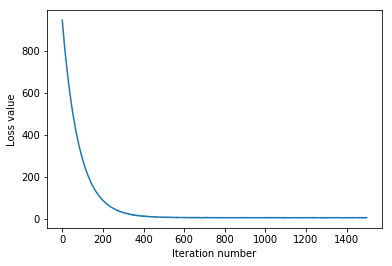

training accuracy: 0.369163
validation accuracy: 0.384000
Learning Rate: 0.000000.10
Regularization Strength: 25000.000000.1


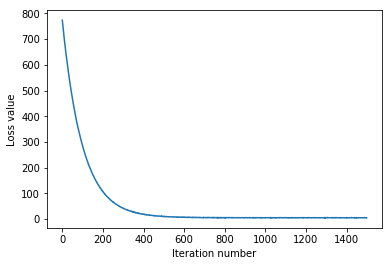

training accuracy: 0.367735
validation accuracy: 0.385000
Learning Rate: 0.000000.10
Regularization Strength: 10000.000000.1


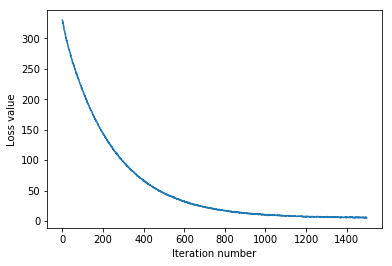

training accuracy: 0.382224
validation accuracy: 0.388000
Learning Rate: 0.000000.10
Regularization Strength: 7000.000000.1


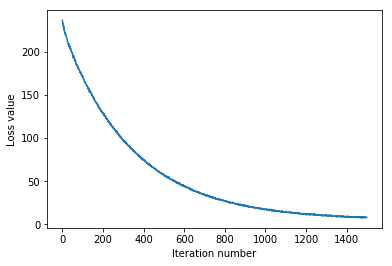

training accuracy: 0.386163
validation accuracy: 0.385000
Learning Rate: 0.000005.10
Regularization Strength: 50000.000000.1


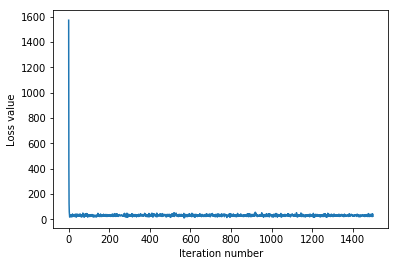

training accuracy: 0.209082
validation accuracy: 0.220000
Learning Rate: 0.000005.10
Regularization Strength: 30000.000000.1


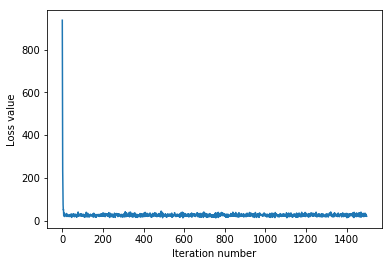

training accuracy: 0.199857
validation accuracy: 0.216000
Learning Rate: 0.000005.10
Regularization Strength: 25000.000000.1


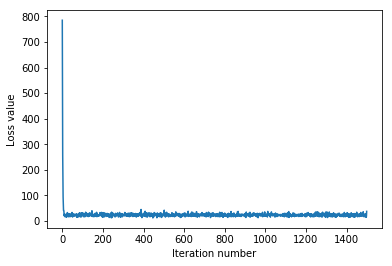

training accuracy: 0.199673
validation accuracy: 0.220000
Learning Rate: 0.000005.10
Regularization Strength: 10000.000000.1


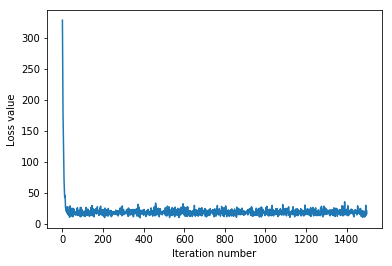

training accuracy: 0.207653
validation accuracy: 0.212000
Learning Rate: 0.000005.10
Regularization Strength: 7000.000000.1


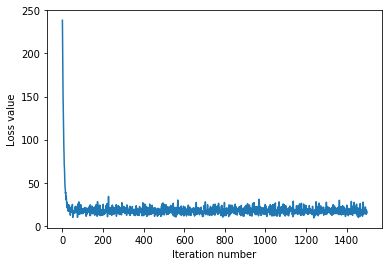

training accuracy: 0.216918
validation accuracy: 0.213000
Learning Rate: 0.000003.10
Regularization Strength: 50000.000000.1


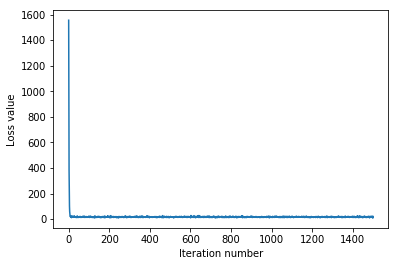

training accuracy: 0.183306
validation accuracy: 0.189000
Learning Rate: 0.000003.10
Regularization Strength: 30000.000000.1


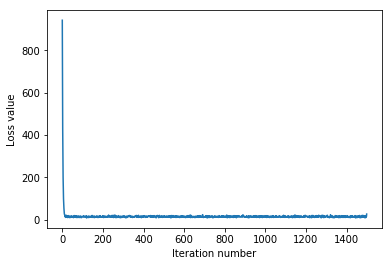

training accuracy: 0.229694
validation accuracy: 0.236000
Learning Rate: 0.000003.10
Regularization Strength: 25000.000000.1


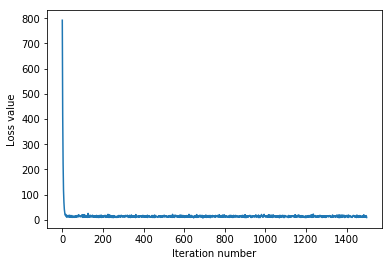

training accuracy: 0.230245
validation accuracy: 0.245000
Learning Rate: 0.000003.10
Regularization Strength: 10000.000000.1


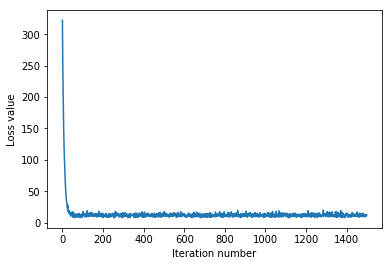

training accuracy: 0.243898
validation accuracy: 0.240000
Learning Rate: 0.000003.10
Regularization Strength: 7000.000000.1


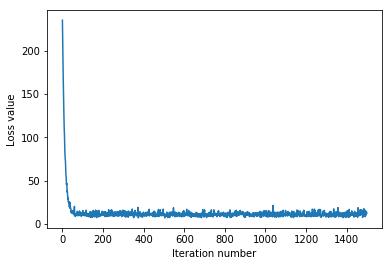

training accuracy: 0.240469
validation accuracy: 0.245000
Learning Rate: 0.000001.10
Regularization Strength: 50000.000000.1


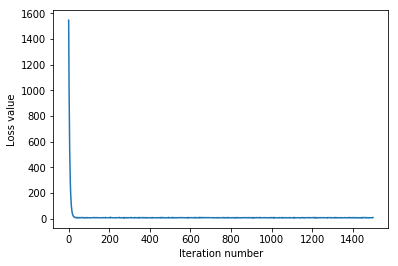

training accuracy: 0.226265
validation accuracy: 0.230000
Learning Rate: 0.000001.10
Regularization Strength: 30000.000000.1


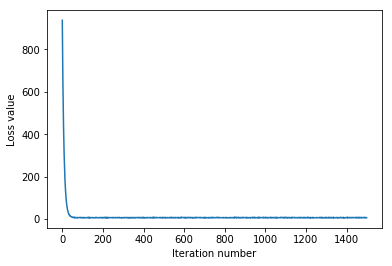

training accuracy: 0.261510
validation accuracy: 0.275000
Learning Rate: 0.000001.10
Regularization Strength: 25000.000000.1


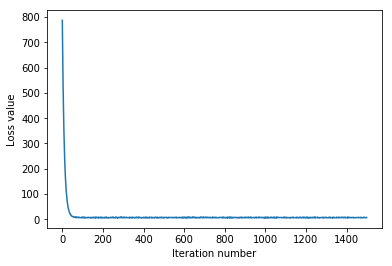

training accuracy: 0.304061
validation accuracy: 0.306000
Learning Rate: 0.000001.10
Regularization Strength: 10000.000000.1


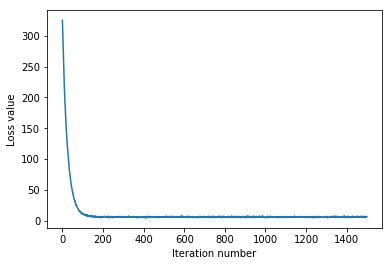

training accuracy: 0.318714
validation accuracy: 0.318000
Learning Rate: 0.000001.10
Regularization Strength: 7000.000000.1


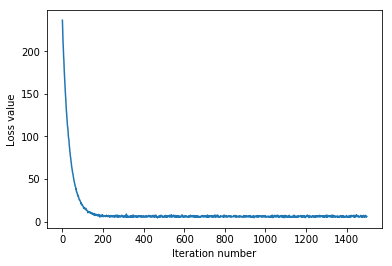

training accuracy: 0.324612
validation accuracy: 0.349000
lr 1.000000e-08 reg 7.000000e+03 train accuracy: 0.225388 val accuracy: 0.246000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.237408 val accuracy: 0.239000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.251510 val accuracy: 0.259000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.253184 val accuracy: 0.244000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.304959 val accuracy: 0.319000
lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.386163 val accuracy: 0.385000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.382224 val accuracy: 0.388000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367735 val accuracy: 0.385000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.369163 val accuracy: 0.384000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.361184 val accuracy: 0.387000
lr 5.000000e-07 reg 7.000000e+03 train accuracy: 0.348041 val accuracy: 0.371000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.

In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
from itertools import product
from deep_learning_su.classifiers import LinearSVM
learning_rates = [1e-8, 5e-7, 1e-7, 5e-6, 3e-6, 1e-6]
regularization_strengths = [5e4, 3e4, 2.5e4, 1e4, 7e3]
# learning_rates = [1e-7]
# regularization_strengths = [5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr, reg in product(learning_rates, regularization_strengths):
    print("Learning Rate: %f.10\nRegularization Strength: %f.1" % (lr, reg))
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
    
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % training_accuracy)
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_accuracy)
    results[(lr, reg)] = (training_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

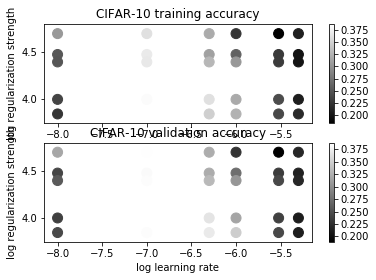

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.379000


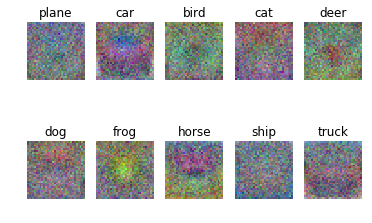

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [21]:
best_svm = LinearSVM()
best_svm.train(X_train, y_train, num_iters=1500, learning_rate=1e-7, reg=2.5e4, verbose=False);

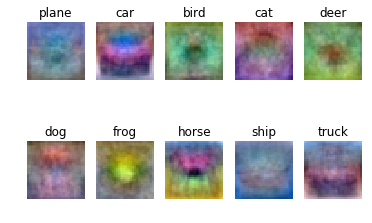

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The weights actually try to make the best approximation for what for instance a car is. The weights serve as a template for the inputs and if the input is very close to a template the model predicts its class with higher probability. Based on the provider training data it probably saw that many of the cars were red and were shot from the front. We can also see the plane and the ship classes. They both have a lot of blue and is probably because of the color of the sky and the color of the sea. I find the horse class interesting because is has green for the grass and it has something that looks like a horse but has 2 heads. That seems to be an effect from having training examples for horses facing different directions and it seems that the model tries to match bot directions.

This is all true when the model is not overfitting. If we use regularization 5e4 and learning rate 1e-7 the weights are looking close to normal pictures. So the model is trying to generalize the data and it seems to be generalizing it well.

If the try to reduce the regularization the model performs better on the validation set and better even on the test set but it does not generalize better. The weights try to match single pixels and seem to be overfitting.